In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from sklearn.metrics import mean_squared_error
from scipy import stats

In [4]:
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.al import top_model as topmodel
from DomainPrediction.al.embeddings import one_hot_encode

2025-01-10 02:45:49.586543: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-10 02:45:49.589998: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-10 02:45:49.596288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-10 02:45:49.608064: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-10 02:45:49.608083: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting t

#### Load Data

In [5]:
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/al_test_experiments/Tdomain'

In [6]:
file = os.path.join(data_path, 'dataset_tdomain.csv')
df = pd.read_csv(file)

In [7]:
df.head()

,name,seq,fitness_raw,split_id,n_mut,fitness_log
0,WT,APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALG...,1.000000,2,0,0.000000
1,ESM1,APEDSSFPRPPYAAPEGEIEQTLAGIWMELLGVERVGRHDSFFALG...,0.982485,2,44,-0.017670
2,ESM2,APSEDAYPRATYEAPEGETEQLLAGIWMDLLQVDRVGRHDSFFELG...,0.968661,1,45,-0.031841
3,ESM3,APSEDSYPRPAYVAPEGPTEQLLAGIWQELLNVSKVGRDDSFFDLG...,0.039853,2,46,-3.222547
4,ESM4,APEEASYPREPYVAPQGETEQLLASIWQELLGVERVGAGDNFFELG...,0.457921,2,43,-0.781059


In [8]:
def get_split_mask(df, omit_zero=False):
    if omit_zero:
        train_mask = (df['split_id'] == 2) & (df['fitness_raw'] != 0)
    else:
        train_mask = (df['split_id'] == 2)

    val_mask = df['split_id'] == 1
    test_mask = df['split_id'] == 0

    return train_mask, val_mask, test_mask

#### Models

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from peft import LoraConfig, get_peft_model

In [10]:
class ProteinFunDatasetContrast(Dataset):
    def __init__(self, df, wt):
        self.seq, self.y = df['seq'].to_numpy(), df['fitness_raw'].to_numpy()
        self.wt = np.array([wt]*self.seq.shape[0], dtype='object')
        self.n_mut = df['n_mut'].to_numpy()

        self.positions = []
        for _, row in tqdm(df.iterrows()):
            mt_sequence = row['seq']
            pos = []
            for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt)):
                if aa_wt != aa_mt:
                    ## mutation pos
                    pos.append(i)

            assert len(pos) == row['n_mut']

            self.positions.append(np.array(pos))

        assert len(self.positions) == self.seq.shape[0]
    
    def __len__(self):
        return self.seq.shape[0]
    
    def __getitem__(self, idx):
        return self.seq[idx], self.y[idx], self.wt[idx], self.positions[idx], self.n_mut[idx]
    
    @staticmethod
    def collate_fn(data):
        seq = np.array([x[0] for x in data], dtype='object')
        y = torch.tensor([x[1] for x in data])
        wt = np.array([x[2] for x in data], dtype='object')
        pos = [x[3] for x in data]
        n_mut = np.array([x[4] for x in data])
        return seq, y, wt, pos, n_mut

In [11]:
df.head()

,name,seq,fitness_raw,split_id,n_mut,fitness_log
0,WT,APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALG...,1.000000,2,0,0.000000
1,ESM1,APEDSSFPRPPYAAPEGEIEQTLAGIWMELLGVERVGRHDSFFALG...,0.982485,2,44,-0.017670
2,ESM2,APSEDAYPRATYEAPEGETEQLLAGIWMDLLQVDRVGRHDSFFELG...,0.968661,1,45,-0.031841
3,ESM3,APSEDSYPRPAYVAPEGPTEQLLAGIWQELLNVSKVGRDDSFFDLG...,0.039853,2,46,-3.222547
4,ESM4,APEEASYPREPYVAPQGETEQLLASIWQELLGVERVGAGDNFFELG...,0.457921,2,43,-0.781059


In [12]:
wt_sequence = df.loc[df['name'] == 'WT', 'seq'].iloc[0]

In [13]:
dataset = ProteinFunDatasetContrast(df=df, wt=wt_sequence)

78it [00:00, 35498.67it/s]


In [14]:
dataset[20:23]

(array(['APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVREIERQRRIGLGQSVQTLFQHPTLSVEAQSLVPHREISVPDNGITADTTVLTPAMLPLIDLT',
        'APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVRMIARLRRIGLGLSVQTLFQHPTLSVLAQSLVPHREISVPDNGITADTTVLTPAMLPLIDLT',
        'APGEDAFARQAYQAPQGEIEIALATIWRELLNTEQSGRHDSFFAFGGHSLLAVRMIERLRRIGLGLSVQTLFQHPTLSVLAQSLVPHREISVPDNGITADTTVLTPAMLPLIDLT'],
       dtype=object),
 array([0.        , 0.74444439, 0.07002646]),
 array(['APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVRMIERLRRIGLGLSVQTLFQHPTLSVLAQSLVPHREISVPDNGITADTTVLTPAMLPLIDLT',
        'APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVRMIERLRRIGLGLSVQTLFQHPTLSVLAQSLVPHREISVPDNGITADTTVLTPAMLPLIDLT',
        'APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALGGHSLLAVRMIERLRRIGLGLSVQTLFQHPTLSVLAQSLVPHREISVPDNGITADTTVLTPAMLPLIDLT'],
       dtype=object),
 [array([54, 58, 65, 79]), array([56]), array([32, 35, 44])],
 array([4, 1, 3]))

In [15]:
import esm

In [16]:
class ESM2ConFit(pl.LightningModule):
    def __init__(self, config) -> None:
        super().__init__()
        self.config = config

        self.basemodel, self.alphabet = esm.pretrained.load_model_and_alphabet(config['model_path'])
        self.model_reg, _ = esm.pretrained.load_model_and_alphabet(config['model_path'])
        self.batch_converter = self.alphabet.get_batch_converter()
        
        for pm in self.model_reg.parameters():
            pm.requires_grad = False
        self.model_reg.eval()
        
        peft_config = LoraConfig(
            r=8,
            lora_alpha=8,
            lora_dropout=0.1,
            target_modules=["q_proj", "v_proj"],
            bias='all'
        )
        
        self.model = get_peft_model(self.basemodel, peft_config)
        
        if config['device'] == 'gpu':
            self.model.cuda()
            self.model_reg.cuda()

        self.lambda_reg = config['lambda']

        self.accumulate_batch_loss_train = []
        self.accumulate_batch_loss_val = []
        self.debug=True

    def forward(self, batch, batch_tokens_masked, batch_tokens, batch_tokens_wt):
        mt_seq, _, wt_seq, pos, n_mut = batch
        
        logits = self.model(batch_tokens_masked)['logits']
        log_probs = torch.log_softmax(logits, dim=-1)

        scores = torch.zeros(log_probs.shape[0])
        if self.config['device'] == 'gpu':
            scores = scores.cuda()

        for i in range(log_probs.shape[0]):
            scores[i] = torch.sum(log_probs[i, pos[i]+1, batch_tokens[i][pos[i]+1]] - log_probs[i, pos[i]+1, batch_tokens_wt[i][pos[i]+1]])
        
        return scores, logits
    
    def BT_loss(self, scores, y):
        loss = torch.tensor(0.)
        if self.config['device'] == 'gpu':
            loss = loss.cuda()

        for i in range(len(scores)):
            for j in range(i, len(scores)):
                if y[i] > y[j]:
                    loss += torch.log(1 + torch.exp(scores[j]-scores[i]))
                else:
                    loss += torch.log(1 + torch.exp(scores[i]-scores[j]))
        return loss

    def training_step(self, batch, batch_idx):
        mt_seq, y, wt_seq, pos, n_mut = batch
        data = [
            (f'P{i}', wt_i) for i, wt_i in enumerate(wt_seq)
            ]
        _, _, batch_tokens_wt = self.batch_converter(data)

        data = [
            (f'P{i}', s) for i, s in enumerate(mt_seq)
            ]
        batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
        batch_lens = (batch_tokens != self.alphabet.padding_idx).sum(1)

        batch_tokens_masked = batch_tokens.clone()
        for i in range(batch_tokens.shape[0]):
            if len(pos[i]) > 0:
                batch_tokens_masked[i, pos[i]+1] = self.alphabet.mask_idx
        
        if self.config['device'] == 'gpu':
            batch_tokens_masked = batch_tokens_masked.cuda()

        y_hat, logits = self(batch, batch_tokens_masked, batch_tokens, batch_tokens_wt)

        bt_loss = self.BT_loss(y_hat, y)

        if self.config['device'] == 'gpu':
            batch_tokens_wt = batch_tokens_wt.cuda()

        logits_reg = self.model_reg(batch_tokens_wt)['logits']

        creterion_reg = torch.nn.KLDivLoss(reduction='batchmean')
        probs = torch.softmax(logits, dim=-1)
        probs_reg = torch.softmax(logits_reg, dim=-1)
        l_reg = creterion_reg(probs_reg.log().cuda(), probs)

        loss = bt_loss + self.lambda_reg*l_reg

        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=y.shape[0])
        self.accumulate_batch_loss_train.append(loss.item())
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        mt_seq, y, wt_seq, pos, n_mut = batch
        data = [
            (f'P{i}', wt_i) for i, wt_i in enumerate(wt_seq)
            ]
        _, _, batch_tokens_wt = self.batch_converter(data)

        data = [
            (f'P{i}', s) for i, s in enumerate(mt_seq)
            ]
        batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
        batch_lens = (batch_tokens != self.alphabet.padding_idx).sum(1)

        batch_tokens_masked = batch_tokens.clone()
        for i in range(batch_tokens.shape[0]):
            if len(pos[i]) > 0:
                batch_tokens_masked[i, pos[i]+1] = self.alphabet.mask_idx
        
        if self.config['device'] == 'gpu':
            batch_tokens_masked = batch_tokens_masked.cuda()

        y_hat, logits = self(batch, batch_tokens_masked, batch_tokens, batch_tokens_wt)

        bt_loss = self.BT_loss(y_hat, y)

        if self.config['device'] == 'gpu':
            batch_tokens_wt = batch_tokens_wt.cuda()

        logits_reg = self.model_reg(batch_tokens_wt)['logits']

        creterion_reg = torch.nn.KLDivLoss(reduction='batchmean')
        probs = torch.softmax(logits, dim=-1)
        probs_reg = torch.softmax(logits_reg, dim=-1)
        l_reg = creterion_reg(probs_reg.log().cuda(), probs)

        loss = bt_loss + self.lambda_reg*l_reg

        self.log("val/loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=y.shape[0])
        self.accumulate_batch_loss_val.append(loss.item())

    def trainmodel(self, df, wt, val=None, debug=True):
        self.model.train()
        
        self.debug = debug

        train_dataset = ProteinFunDatasetContrast(df, wt)

        val_loader = None
        if val is not None:
            val_dataset = ProteinFunDatasetContrast(val, wt)
            val_loader = DataLoader(val_dataset, batch_size=self.config['batch_size'], collate_fn=ProteinFunDatasetContrast.collate_fn, shuffle=False)
        
        train_loader = DataLoader(train_dataset, batch_size=self.config['batch_size'], collate_fn=ProteinFunDatasetContrast.collate_fn, shuffle=True)
        # train_loader = DataLoader(train_dataset, batch_size=self.config['batch_size'], collate_fn=ProteinFunDatasetContrast.collate_fn, shuffle=False)

        callbacks = None
        if self.config['early_stopping']:
            callbacks = []
            earlystopping_callback = EarlyStopping(monitor="val/loss", patience=self.config['patience'], verbose=False, mode="min")
            callbacks.append(earlystopping_callback)


        trainer = pl.Trainer(max_epochs=self.config['epoch'], callbacks=callbacks,
                                accelerator="auto",
                                enable_progress_bar=False,
                                enable_model_summary=True,
                                precision="16-mixed",
                                # accumulate_grad_batches=self.config['accumulate_batch_size']
                                )
        
        trainer.fit(model=self, train_dataloaders=train_loader, val_dataloaders=val_loader)

    def sanity_check(self, df, wt):
        dataset = ProteinFunDatasetContrast(df, wt)
        loader = DataLoader(dataset, batch_size=self.config['batch_size'], collate_fn=ProteinFunDatasetContrast.collate_fn, shuffle=False)

        y_pred_1 = []
        for batch in loader:
            mt_seq, y, wt_seq, pos, n_mut = batch
            data = [
                (f'P{i}', wt_i) for i, wt_i in enumerate(wt_seq)
                ]
            _, _, batch_tokens_wt = self.batch_converter(data)

            data = [
                (f'P{i}', s) for i, s in enumerate(mt_seq)
                ]
            batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
            batch_lens = (batch_tokens != self.alphabet.padding_idx).sum(1)

            batch_tokens_masked = batch_tokens.clone()
            for i in range(batch_tokens.shape[0]):
                if len(pos[i]) > 0:
                    batch_tokens_masked[i, pos[i]+1] = self.alphabet.mask_idx
            
            if self.config['device'] == 'gpu':
                batch_tokens_masked = batch_tokens_masked.cuda()

            with torch.no_grad():
                y_hat, _ = self(batch, batch_tokens_masked, batch_tokens, batch_tokens_wt)

            y_pred_1.append(y_hat.cpu().numpy())

        y_pred_1 = np.concatenate(y_pred_1)

        y_pred_2 = []
        for i, row in df.iterrows():
            mt_sequence = row['seq']
            score, n_muts = self.get_masked_marginal(mt_sequence, wt_sequence)
            assert n_muts == row['n_mut']

            y_pred_2.append(score)

        y_pred_2 = np.array(y_pred_2)

        np.allclose(y_pred_1, y_pred_2, atol=1e-3)
            
    def on_train_epoch_start(self):
        self.accumulate_batch_loss_train.clear()
        self.accumulate_batch_loss_val.clear()
    
    def on_train_epoch_end(self):
        if self.current_epoch % self.config['print_every_n_epoch'] == 0 and self.debug:
            print(f'Epoch: {self.current_epoch}: train loss: {np.mean(self.accumulate_batch_loss_train)} val loss: {np.mean(self.accumulate_batch_loss_val)}')

    def on_train_end(self):
        print(f'Epoch: {self.current_epoch}: train loss: {np.mean(self.accumulate_batch_loss_train)} val loss: {np.mean(self.accumulate_batch_loss_val)}')

    def get_log_prob(self, sequence):
        data = [
            ("protein1", sequence)
        ]
        batch_labels, batch_strs, batch_tokens = self.batch_converter(data)
        batch_lens = (batch_tokens != self.alphabet.padding_idx).sum(1)

        if self.config['device'] == 'gpu':
            batch_tokens = batch_tokens.cuda()
            self.model = self.model.cuda()

        with torch.no_grad():
            logits = self.model(batch_tokens)['logits']

        log_prob = torch.log_softmax(logits, dim=-1)[0,1:-1,:]

        return log_prob.cpu().numpy()
    
    def get_wildtype_marginal(self, mt_sequence, wt_sequence, wt_log_prob=None):
        if wt_log_prob is None:
            assert len(wt_sequence) == len(mt_sequence)
            wt_log_prob = self.get_log_prob(sequence=wt_sequence)

        assert wt_log_prob.shape[0] == len(wt_sequence) == len(mt_sequence)

        n_muts = 0
        score = 0
        for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt_sequence)):
            if aa_wt != aa_mt:
                ## mutation pos
                n_muts += 1

                idx_mt = self.alphabet.get_idx(aa_mt)
                idx_wt = self.alphabet.get_idx(aa_wt)
                score += wt_log_prob[i, idx_mt] - wt_log_prob[i, idx_wt]


        return score, n_muts
    
    def get_masked_marginal(self, mt_sequence, wt_sequence, mask_token = '<mask>'):

        assert len(wt_sequence) == len(mt_sequence)

        n_muts = 0
        mask_positions = []
        for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt_sequence)):
            if aa_wt != aa_mt:
                ## mutation pos
                n_muts += 1
                mask_positions.append(i)

        assert len(mask_positions) == n_muts
        masked_query = list(wt_sequence)
        for _pos in mask_positions:
            masked_query[_pos] = mask_token
        masked_sequence = ''.join(masked_query)

        masked_log_prob = self.get_log_prob(sequence=masked_sequence)
        
        score = 0
        _idx = 0
        for i, (aa_mt, aa_wt) in enumerate(zip(mt_sequence, wt_sequence)):
            if aa_wt != aa_mt:
                ## mutation pos

                assert mask_positions[_idx] == i
                _idx += 1

                idx_mt = self.alphabet.get_idx(aa_mt)
                idx_wt = self.alphabet.get_idx(aa_wt)
                score += masked_log_prob[i, idx_mt] - masked_log_prob[i, idx_wt]


        return score, n_muts
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.config['lr'])

In [17]:
config={'model_path': '/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt',
        'epoch': 3, 
        'batch_size': 8,
        'lambda': 0.1,
        'accumulate_batch_size': 32,
        'patience': 10,
        'early_stopping': False,
        'lr': 5e-4,
        'print_every_n_epoch': 1,
        'device': 'gpu'}
surrogate = ESM2ConFit(config=config)
surrogate.model.print_trainable_parameters()

trainable params: 1,820,194 || all params: 652,394,934 || trainable%: 0.2790


In [18]:
df_train = df[df['split_id'] == 2]
df_val = df[df['split_id'] == 1]
df_test = df[df['split_id'] == 0]

In [19]:
surrogate.sanity_check(df_train, wt_sequence)

53it [00:00, 34411.47it/s]


In [20]:
surrogate.config['epoch'] = 10

In [34]:
surrogate.trainmodel(df_test, wt_sequence, df_val)

18it [00:00, 26123.69it/s]
7it [00:00, 24713.91it/s]
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | basemodel | ESM2      | 652 M  | train
1 | model_reg | ESM2      | 651 M  | eval 
2 | model     | PeftModel | 652 M  | train
------------------------------------------------
1.8 M     Trainable params
1.3 B     Non-trainable params
1.3 B     Total params
5,213.753 Total estimated model params size (MB)
/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/nethome

Epoch: 0: train loss: 27.09157594045003 val loss: 24.411895751953125
Epoch: 1: train loss: 21.768344243367512 val loss: 24.743803024291992
Epoch: 2: train loss: 22.158036867777508 val loss: 24.578582763671875
Epoch: 3: train loss: 24.41206169128418 val loss: 25.088115692138672
Epoch: 4: train loss: 19.769171078999836 val loss: 26.250396728515625
Epoch: 5: train loss: 19.433066685994465 val loss: 27.267383575439453
Epoch: 6: train loss: 17.300061384836834 val loss: 28.614238739013672
Epoch: 7: train loss: 18.91380230585734 val loss: 29.322420120239258
Epoch: 8: train loss: 18.30318530400594 val loss: 30.186765670776367
Epoch: 9: train loss: 17.326273918151855 val loss: 30.481788635253906


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch: 10: train loss: 17.326273918151855 val loss: 30.481788635253906


In [35]:
def see_pred(df):
    ## masked marginals
    y_pred = []
    for i, row in tqdm(df.iterrows()):
        mt_sequence = row['seq']
        score, n_muts = surrogate.get_masked_marginal(mt_sequence, wt_sequence)

        assert n_muts == row['n_mut']

        y_pred.append(score)

    y_pred = np.array(y_pred)

    y = df['fitness_log'].to_numpy().astype(np.float32)

    fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')

    ax[0].plot(y, y_pred, '.', alpha=0.5)
    mse = mean_squared_error(y, y_pred)
    corr = stats.spearmanr(y, y_pred)
    s_corr = round(corr.statistic, 2)
    ax[0].set_title(f'Full Dataset \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

    mask = ~(df['fitness_raw'] == 0)
    ax[1].plot(y[mask], y_pred[mask], '.', alpha=0.5)
    mse = mean_squared_error(y[mask], y_pred[mask])
    corr = stats.spearmanr(y[mask], y_pred[mask])
    s_corr = round(corr.statistic, 2)
    ax[1].set_title(f'Omit fitness = 0 \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

    for i in range(2):
        ax[i].set_xlabel('True')
        ax[i].set_ylabel('Pred')

    plt.show()

In [36]:
df_test.shape

(18, 6)

53it [00:03, 14.74it/s]


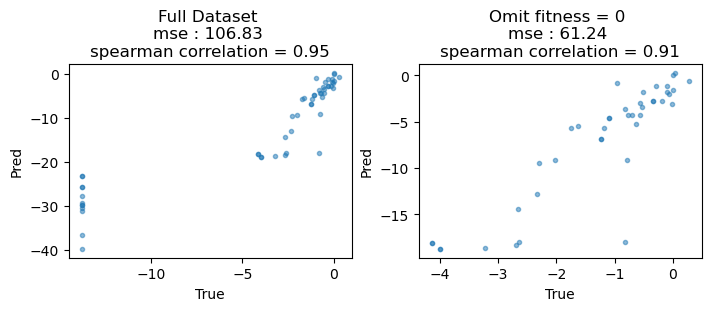

In [37]:
see_pred(df_train)

7it [00:00, 15.74it/s]


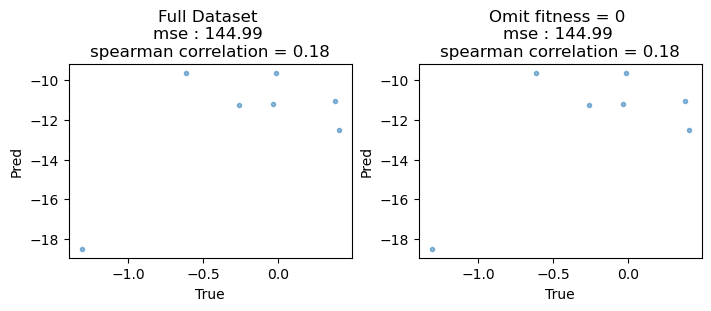

In [38]:
see_pred(df_val)

18it [00:01, 15.74it/s]


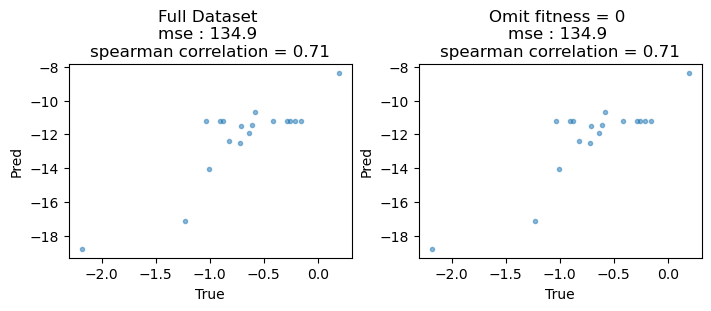

In [39]:
see_pred(df_test)

53it [00:03, 15.74it/s]


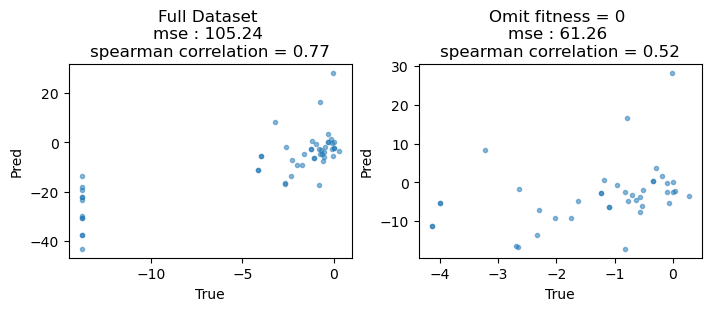

In [22]:
see_pred(df_train)

7it [00:00, 15.81it/s]


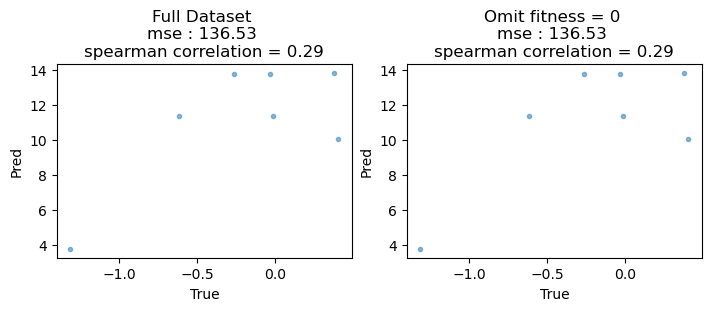

In [23]:
see_pred(df_val)

18it [00:01, 15.71it/s]


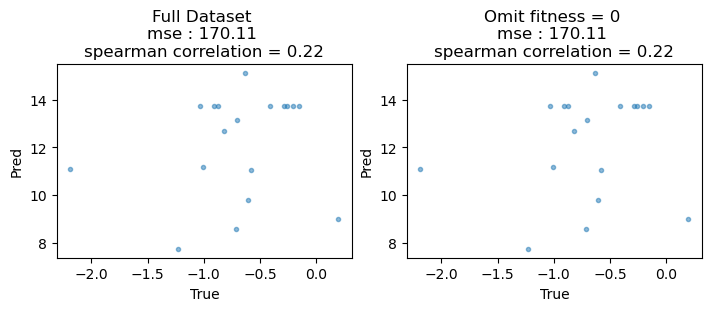

In [24]:
see_pred(df_test)